<a href="https://colab.research.google.com/github/jenniferhiga/HCI_AI_RoboticSurgery/blob/main/JH_Grounded_SAM_Tool_Instance_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download Requirements

In [1]:
# !git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

# %cd /content/Grounded-Segment-Anything
# !pip install -q -r requirements.txt
# %cd /content/Grounded-Segment-Anything/GroundingDINO
# !pip install -q .
# %cd /content/Grounded-Segment-Anything

In [2]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# def download_image(url, image_file_path):
#     r = requests.get(url, timeout=4.0)
#     if r.status_code != requests.codes.ok:
#         assert False, 'Status code error: {}.'.format(r.status_code)

#     with Image.open(BytesIO(r.content)) as im:
#         im.save(image_file_path)
#     print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

# local_image_path = "inpaint_demo.jpg"
# image_url = "https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg"

# download_image(image_url, local_image_path)
# image_source, image = load_image(local_image_path)
# plt.imshow(image_source)

In [3]:
!pip -q install groundingdino-py


import PIL
from PIL import Image
import requests
import torch
from io import BytesIO
# if install from github repository
# from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

# if install from python package
from groundingdino.util.inference import annotate, load_image, predict
import torch
from huggingface_hub import hf_hub_download
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(BytesIO(r.content)) as im:
        im.save(image_file_path)
    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

local_image_path = "inpaint_demo.jpg"
image_url = "https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg"

download_image(image_url, local_image_path)
image_source, image = load_image(local_image_path)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 862.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.2 MB/s eta 0:00:00
Image downloaded from url: https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg and saved to: inpaint_demo.jpg.


In [4]:
# /////////////// Import libraries and packages ///////////////
# import PIL
# from PIL import Image
# import requests
# import torch
from io import BytesIO
# from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict
from huggingface_hub import hf_hub_download
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from skimage import exposure
from skimage.filters import gaussian
from PIL import Image, ImageEnhance, ImageFilter
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF
from torchvision.transforms import v2 as v2

In [5]:
class perturbation_class:

    def gamma_correction(img):
        seq = []
        gammas = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]#np.arange(1,0.1,-.03)
        img = Image.fromarray(img)
        for i in range(len(gammas)):
            z = TF.adjust_gamma(img, gammas[i], gain=1)
            seq.append(z)
        return seq

    def contrast(img):
        seq = []
        factors = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
        img = Image.fromarray(img)
        for i in range(len(factors)):
            z = TF.adjust_contrast(img, factors[i])
            seq.append(z)
        return seq

    def brightness(img):
        seq = []
        factors = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
        img = Image.fromarray(img)
        for i in range(len(factors)):
            z = TF.adjust_brightness(img, factors[i])
            seq.append(z)
        return seq

    def sharpness(img):
        seq = []
        #factors = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
        factors = [ -6, -4, -2, 1, 2, 4, 6]
        img = Image.fromarray(img)
        for i in range(len(factors)):
            z = TF.adjust_sharpness(img, factors[i])
            seq.append(z)
        return seq

    def gaussian_blur(img):
        seq = []
        ksize = [1, 3, 5, 7, 9, 11, 51]
        img = Image.fromarray(img)
        for i in range(len(ksize)):
            z = TF.gaussian_blur(img, kernel_size=ksize[i])
            seq.append(np.array(z))
        return seq


In [6]:
img_dir = 'inpaint_demo.jpg'
original = cv2.imread(img_dir)
perturbation_all = ['gamma_correction', 'contrast', 'brightness', 'sharpness','gaussian_blur']
filter_name = ['gc', 'con', 'bri', 'sha','blu']
levels_real = [0.4, 1.6]
!mkdir perturbed_imgs
cv2.imwrite('perturbed_imgs/origin.png', original)
for p_idx, per in enumerate(perturbation_all):
    class_method = getattr(perturbation_class, per)
    seq = class_method(original)
    cv2.imwrite('perturbed_imgs/{}_0.png'.format(filter_name[p_idx]), np.array(seq[0]))
    cv2.imwrite('perturbed_imgs/{}_6.png'.format(filter_name[p_idx]), np.array(seq[6]))

(706, 884, 3) (3, 800, 1001)


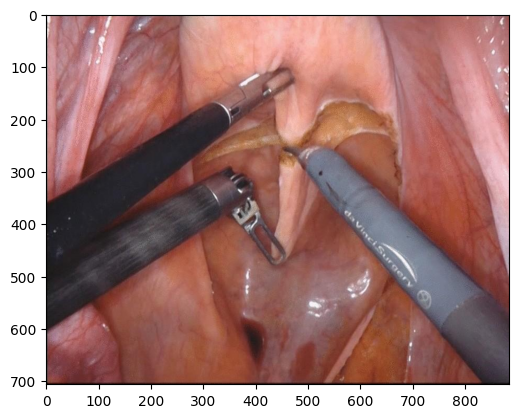

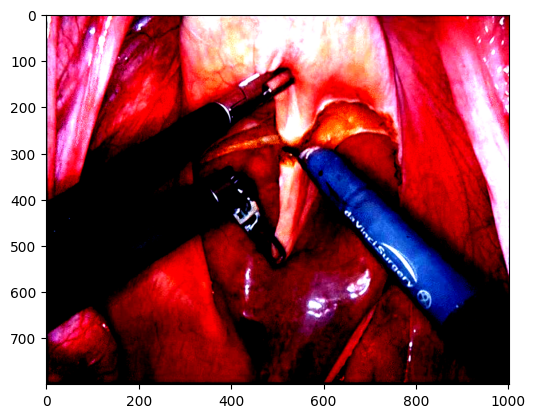

In [7]:
import numpy as np
import matplotlib.pyplot as plt
print(np.array(image_source).shape, np.array(image).shape)
plt.figure()
plt.imshow(np.array(image_source))

plt.figure()
plt.imshow(np.array(image).transpose(1,2,0))

In [8]:
# img_dir = 'inpaint_demo.jpg'
# original = cv2.imread(img_dir)
# plt.rcParams.update({'font.size': 14})
# ptech_list = ['Original', '+1', '+2', '+3', '+4', '+5', '+6']
# f_size = 8
# perturbation_all = ['gamma_correction', 'contrast', 'brightness', 'sharpness','gaussian_blur']
# filter_name = ['Gamma Correction\n(GC)', 'Contrast\n(Con)', 'Brightness\n(Bri)', 'Sharpness\n(Sha)','Blur']
# seq_all = [0, 1, 2, 3, 4, 5, 6]
# levels = ['-3','-2','-1','Original','+1','+2','+3']
# levels_real = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
# fig_per_row = len(seq_all)
# fig, ax = plt.subplots(len(perturbation_all), fig_per_row, figsize=(31/3, 25.5/3), gridspec_kw=dict(wspace=0.00, hspace=0.09))
# for p_idx, per in enumerate(perturbation_all):
#     class_method = getattr(perturbation_class, per)
#     seq = class_method(original)
#     for idx, seq_idx in enumerate(seq_all):
#         if p_idx == 4:
#             ax[p_idx, idx].set_title('{}'.format(ptech_list[idx]), fontsize=f_size)
#         if idx == 3:
#             #seq[seq_idx] = cv2.cvtColor(seq[seq_idx], cv2.COLOR_BGR2RGB)
#             ax[p_idx, idx].imshow(seq[seq_idx])#, cmap='gray')
#         else:
#             #seq[seq_idx] = cv2.cvtColor(seq[seq_idx], cv2.COLOR_BGR2RGB)
#             ax[p_idx, idx].imshow(seq[seq_idx])#, cmap='gray')

#         if p_idx == 0:
#             if levels[idx] == 'Original':
#                 ax[p_idx, idx].set_title('\n{}'.format(levels[idx]), fontsize=f_size)
#             else:
#                 ax[p_idx, idx].set_title('{}'.format(levels[idx], levels_real[idx]), fontsize=f_size)
#         if idx == 0:
#             ax[p_idx, idx].set_ylabel(filter_name[p_idx], fontsize=f_size, fontweight="bold")

#         ax[p_idx, idx].xaxis.set_major_locator(plt.NullLocator())
#         ax[p_idx, idx].yaxis.set_major_locator(plt.NullLocator())


# fig.show()
# plt.savefig('perturbation_effect_v2.pdf',dpi=100)

In [9]:
# img_dir = 'inpaint_demo.jpg'
# original = cv2.imread(img_dir)
# plt.rcParams.update({'font.size': 14})
# ptech_list = ['Original', '+1', '+2', '+3', '+4', '+5', '+6']
# f_size = 8
# perturbation_all = ['gamma_correction', 'contrast', 'brightness', 'sharpness','gaussian_blur']
# filter_name = ['Gamma Correction\n(GC)', 'Contrast\n(Con)', 'Brightness\n(Bri)', 'Sharpness\n(Sha)','Blur']
# seq_all = [0, 1, 2, 3, 4, 5, 6]
# levels = ['-3','-2','-1','Original','+1','+2','+3']
# levels_real = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
# fig_per_row = len(seq_all)
# fig, ax = plt.subplots(len(perturbation_all), fig_per_row, figsize=(31/3, 25.5/3), gridspec_kw=dict(wspace=0.00, hspace=0.09))
# for p_idx, per in enumerate(perturbation_all):
#     class_method = getattr(perturbation_class, per)
#     seq = class_method(original)
#     for idx, seq_idx in enumerate(seq_all):
#       img = seq[seq_idx]
#       #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# # plt.savefig('perturbation_effect_v2.pdf',dpi=100)

In [10]:
import cv2
import numpy as np
import os
from PIL import Image
import torchvision.transforms.functional as TF

def gaussian_blur(img):
    seq = []
    ksize = [1, 3, 5, 7, 9, 11, 51]
    img = Image.fromarray(img)
    for i in range(len(ksize)):
        z = TF.gaussian_blur(img, kernel_size=ksize[i])
        seq.append(np.array(z))
    return seq

img_dir = 'inpaint_demo.jpg'
original = cv2.imread(img_dir)
gaussian_images = gaussian_blur(original)

if not os.path.isdir('gaussian_imgs'):
    os.mkdir('gaussian_imgs')

for idx, img_array in enumerate(gaussian_images):
    corrected = Image.fromarray(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
    corrected.save('gaussian_imgs/gaussian{}.png'.format(idx))

# Assuming gaussian_image[0] is the source image
# corrected0 = cv2.cvtColor(gaussian_images[0], cv2.COLOR_BGR2RGB)
# corrected1 = cv2.cvtColor(gaussian_images[1], cv2.COLOR_BGR2RGB)
# corrected2 = cv2.cvtColor(gaussian_images[2], cv2.COLOR_BGR2RGB)
# corrected3 = cv2.cvtColor(gaussian_images[3], cv2.COLOR_BGR2RGB)
# corrected4 = cv2.cvtColor(gaussian_images[4], cv2.COLOR_BGR2RGB)
# corrected5 = cv2.cvtColor(gaussian_images[5], cv2.COLOR_BGR2RGB)

# plt.imshow(corrected6)
# plt.show()


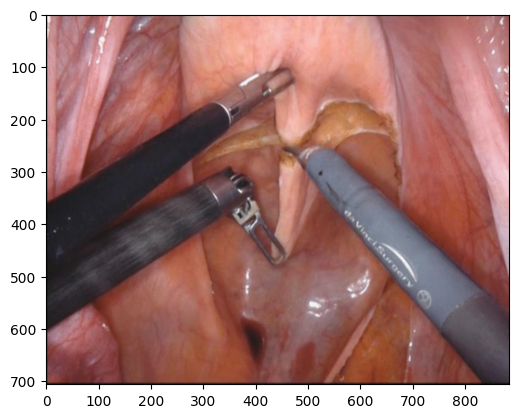

In [11]:
#seq[0] = cv2.cvtColor(seq[0], cv2.COLOR_BGR2RGB)
#plt.imshow(seq[0])

seq[1] = cv2.cvtColor(seq[1], cv2.COLOR_BGR2RGB)
plt.imshow(seq[1])

#seq[2] = cv2.cvtColor(seq[2], cv2.COLOR_BGR2RGB)
#plt.imshow(seq[2])

#seq[3] = cv2.cvtColor(seq[3], cv2.COLOR_BGR2RGB)
#plt.imshow(seq[3])

Cropping

In [12]:
class crop_class:
  def center_crop(img):
    seq = []
    sizes = [50, 150, 250, 350, 450, 550, 700]
    for i in range(len(sizes)):
      z = TF.center_crop(original, sizes[i])
      seq.append(z)
    return seq

  def center_crop_tiny(img):
    seq = []
    sizes = [30, 40, 50, 60, 70, 80, 90]
    for i in range(len(sizes)):
      z = TF.center_crop(original, sizes[i])
      seq.append(z)
    return seq

  def center_crop_big(img):
    seq = []
    sizes = [200, 300, 500, 800, 1000, 1200, 1400]
    for i in range(len(sizes)):
      z = TF.center_crop(original, sizes[i])
      seq.append(z)
    return seq

In [13]:

super_cropped=TF.resized_crop(Image.fromarray(original), 80, 500, 80, 80, 500)
super_cropped.save("NewImage.png")

NameError: ignored

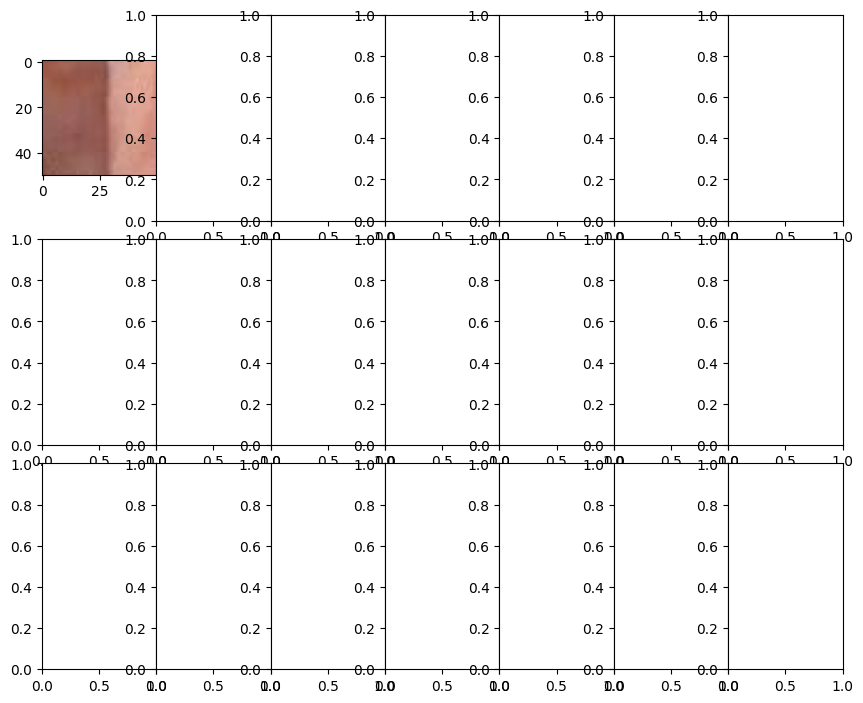

In [14]:
# img_dir = 'inpaint_demo.jpg'
# original = Image.fromarray(image_source)
# crop_type = ['Center Crop', 'Tiny Crop', 'Big Crop']
# seq_all = [0, 1, 2, 3, 4, 5, 6]
# sizes = [50, 150, 250, 350, 450, 550, 700]
# perturbation_crops = ['center_crop','center_crop_tiny', 'center_crop_big']
# if os.path.isdir('cropped_imgs'):
#     print(f"{'cropped_imgs'} exists.")
# else:
#   os.mkdir('cropped_imgs')
# fig_per_row = len(seq_all)
# fig, ax = plt.subplots(len(perturbation_crops), fig_per_row, figsize=(31/3, 25.5/3), gridspec_kw=dict(wspace=0.00, hspace=0.09))
# for p_idx, per in enumerate(perturbation_crops):
#     class_method = getattr(crop_class, per)
#     seq = class_method(original)
#     for idx, seq_idx in enumerate(seq_all):
#       seq[seq_idx].save('cropped_imgs/crop{}.png'.format(seq_idx))
#       ax[p_idx, idx].imshow(seq[seq_idx])
#       if p_idx == 0:
#         ax[p_idx, idx].set_title('Size: ' + '{}'.format(sizes[idx]), fontsize=f_size)
#       if idx == 0:
#         ax[p_idx, idx].set_ylabel(crop_type[p_idx], fontsize=f_size, fontweight="bold")

#       ax[p_idx, idx].xaxis.set_major_locator(plt.NullLocator())
#       ax[p_idx, idx].yaxis.set_major_locator(plt.NullLocator())
# plt.savefig('Crop_Effects.pdf',dpi=100)

This code block below just uses the five crop, but with seven different types to iterate in a grid, did this one separately.

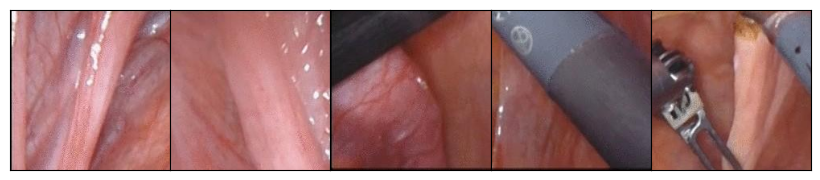

In [15]:
img_dir = 'inpaint_demo.jpg'
original = Image.fromarray(image_source)
if os.path.isdir('fivecrop_imgs'):
    print(f"{'fivecrop_imgs'} exists.")
else:
    os.mkdir('fivecrop_imgs')
seq = []
sizes = [50, 150, 250, 350, 450, 550, 700]
five = TF.five_crop(original, (200, 200))
fig, ax = plt.subplots(1, len(five), figsize=(31/3, 25.5/3), gridspec_kw=dict(wspace=0.00, hspace=0.09))
five_crop_imgs = []
for idx, pic in enumerate(five):
  ax[idx].imshow(pic)
  pic.save('fivecrop_imgs/crop{}.png'.format(idx))
  ax[idx].xaxis.set_major_locator(plt.NullLocator())
  ax[idx].yaxis.set_major_locator(plt.NullLocator())
  five_crop_imgs.append(pic)

Geometrical Deviation

In [16]:
import random
class geometric_class:
  def rotate_pic(img):
    seq = []
    angles = [30, 45, 60, 90, 180, 270, 360]
    for i in range(len(angles)):
      z = TF.rotate(original, angles[i])
      seq.append(z)
    return seq

  def rotate_pic2(img):
    seq = []
    angles = [10, 15, 20, 25, 30, 35, 40]
    for i in range(len(angles)):
      z = TF.rotate(original, angles[i])
      seq.append(z)
    return seq

  def affine(img):
    seq = []
    angles = [10, 15, 20, 25, 30, 35, 40]
    translate = [3,2]
    shear = [-15, -30, -45, -180, 15, 30, 45]
    for i in range(len(angles)):
      z = TF.affine(original, angles[i], translate, random.randint(1,5), shear[i])
      seq.append(z)
    return seq

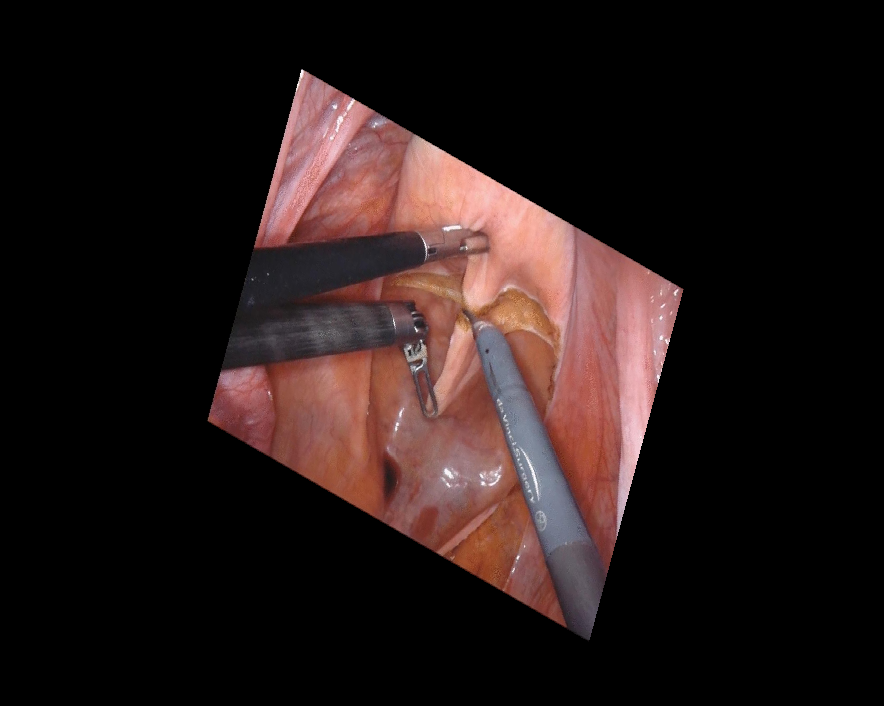

In [17]:
img_dir = 'inpaint_demo.jpg'
original = Image.fromarray(image_source)
TF.affine(original, 30, [3,2], 0.5, -15)

In [19]:
# import os
# img_dir = 'inpaint_demo.jpg'
# original = Image.fromarray(image_source)
# geometry_type = ['Rotate Classics', 'Rotate Random', 'Affine']
# seq_all = [0, 1, 2, 3, 4, 5, 6]
# sizes = [50, 150, 250, 350, 450, 550, 700]
# perturbation_geometry = ['rotate_pic', 'rotate_pic2', 'affine']
# fig_per_row = len(seq_all)
# if os.path.isdir('perturbed_imgs'):
#     print(f"{'perturbed_imgs'} exists.")
# else:
#   os.mkdir('perturbed_imgs')
# fig, ax = plt.subplots(len(perturbation_geometry), fig_per_row, figsize=(31/3, 25.5/3), gridspec_kw=dict(wspace=0.00, hspace=0.09))
# for p_idx, per in enumerate(perturbation_geometry):
#     class_method = getattr(geometric_class, per)
#     seq = class_method(original)
#     for idx, seq_idx in enumerate(seq_all):
#       ax[p_idx, idx].imshow(seq[seq_idx])
#       seq[seq_idx].save('perturbed_imgs/perturbed{}.png'.format(seq_idx))
#       #seq[seq_idx].save('rotated_imgs/rotated{}.png'.format(seq_idx))
#       #if p_idx == 0:
#         #ax[p_idx, idx].set_title('Size: ' + '{}'.format(sizes[idx]), fontsize=f_size)
#       if idx == 0:
#         ax[p_idx, idx].set_ylabel(geometry_type[p_idx], fontsize=f_size, fontweight="bold")

#       ax[p_idx, idx].xaxis.set_major_locator(plt.NullLocator())
#       ax[p_idx, idx].yaxis.set_major_locator(plt.NullLocator())
# plt.savefig('Crop_Effects.pdf',dpi=100)

Adversarial Attacks (for M)

Transposing the images so that they have the same shape that the model takes in

In [20]:
print(seq[0].size, np.array(seq[0]).shape, image.shape)
img_perturb_np = np.array(seq[0]).transpose(2, 0, 1)
img_perturb_tr  = torch.tensor(img_perturb_np)
img_perturb_np.shape, img_perturb_tr.shape

(884, 706) (706, 884, 3) torch.Size([3, 800, 1001])


((3, 706, 884), torch.Size([3, 706, 884]))

Filter implementation

In [21]:
import torchvision.transforms.functional as TF
from PIL import Image
import cv2
import urllib

class perturbation_class:

    def gamma_correction(img):
        seq = []
        gammas = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]#np.arange(1,0.1,-.03)
        img = Image.fromarray(img)
        for i in range(len(gammas)):
            z = TF.adjust_gamma(img, gammas[i], gain=1)
            seq.append(z)
        return seq

    def contrast(img):
        seq = []
        factors = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
        img = Image.fromarray(img)
        for i in range(len(factors)):
            z = TF.adjust_contrast(img, factors[i])
            seq.append(z)
        return seq

    def brightness(img):
        seq = []
        factors = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
        img = Image.fromarray(img)
        for i in range(len(factors)):
            z = TF.adjust_brightness(img, factors[i])
            seq.append(z)
        return seq

    def sharpness(img):
        seq = []
        #factors = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
        factors = [ -6, -4, -2, 1, 2, 4, 6]
        img = Image.fromarray(img)
        for i in range(len(factors)):
            z = TF.adjust_sharpness(img, factors[i])
            seq.append(z)
        return seq

    def gaussian_blur(img):
        seq = []
        ksize = [1, 3, 5, 7, 9, 11, 99]
        img = Image.fromarray(img)
        for i in range(len(ksize)):
            z = TF.gaussian_blur(img, kernel_size=ksize[i])
            seq.append(np.array(z))
        return seq

image_url = "https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg"
local_image_path = 'clean_input.png'
urllib.request.urlretrieve(image_url, local_image_path)
original = cv2.imread(local_image_path)
perturbation_all = ['gamma_correction', 'contrast', 'brightness', 'sharpness','gaussian_blur']
filter_name = ['gc', 'con', 'bri', 'sha','blu']
!mkdir perturbed_imgs
cv2.imwrite('perturbed_imgs/origin.png', original)
for p_idx, per in enumerate(perturbation_all):
    class_method = getattr(perturbation_class, per)
    seq = class_method(original)
    cv2.imwrite('perturbed_imgs/{}_0.png'.format(filter_name[p_idx]), np.array(seq[0]))
    cv2.imwrite('perturbed_imgs/{}_6.png'.format(filter_name[p_idx]), np.array(seq[6]))

mkdir: cannot create directory ‘perturbed_imgs’: File exists


Loading the Affine transformed images into variables to pass into model

In [22]:
# image_source1, imag1 = load_image('/content/Grounded-Segment-Anything/perturbed_imgs/perturbed1.png')
# image_source2, image2 = load_image('/content/Grounded-Segment-Anything/perturbed_imgs/perturbed2.png')
# image_source3, image3 = load_image('/content/Grounded-Segment-Anything/perturbed_imgs/perturbed3.png')
# image_source4, image4 = load_image('/content/Grounded-Segment-Anything/perturbed_imgs/perturbed4.png')
# image_source5, image5 = load_image('/content/Grounded-Segment-Anything/perturbed_imgs/perturbed5.png')
# image_source6, image6 = load_image('/content/Grounded-Segment-Anything/perturbed_imgs/perturbed6.png')

Loading the rotate classics transformed images into variables to pass into model

In [23]:
# image_src_cropped, image_crop = load_image('/content/Grounded-Segment-Anything/cropped_imgs/crop0.png')
# image_src_cropped2, image_crop2 = load_image('/content/Grounded-Segment-Anything/cropped_imgs/crop1.png')
# image_src_cropped3, image_crop3 = load_image('/content/Grounded-Segment-Anything/cropped_imgs/crop2.png')
# image_src_cropped4, image_crop4 = load_image('/content/Grounded-Segment-Anything/cropped_imgs/crop3.png')
# image_src_cropped5, image_crop5 = load_image('/content/Grounded-Segment-Anything/cropped_imgs/crop4.png')
# image_src_cropped6, image_crop6 = load_image('/content/Grounded-Segment-Anything/cropped_imgs/crop5.png')
# image_src_cropped7, image_crop7 = load_image('/content/Grounded-Segment-Anything/cropped_imgs/crop6.png')

Loading the gaussian transformations

In [24]:
# image_src_gauss, image_gauss = load_image('/content/Grounded-Segment-Anything/gaussian_imgs/gaussian0.png')
# image_src_gauss2, image_gauss2 = load_image('/content/Grounded-Segment-Anything/gaussian_imgs/gaussian1.png')
# image_src_gauss3, image_gauss3 = load_image('/content/Grounded-Segment-Anything/gaussian_imgs/gaussian2.png')
# image_src_gauss4, image_gauss4 = load_image('/content/Grounded-Segment-Anything/gaussian_imgs/gaussian3.png')
# image_src_gauss5, image_gauss5 = load_image('/content/Grounded-Segment-Anything/gaussian_imgs/gaussian4.png')
# image_src_gauss6, image_gauss6 = load_image('/content/Grounded-Segment-Anything/gaussian_imgs/gaussian5.png')
# image_source, image = load_image('/content/Grounded-Segment-Anything/gaussian_imgs/gaussian6.png')

Grounding DINO to Detect Object with Prompt

GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


logits: tensor([0.4950, 0.3575, 0.3661])


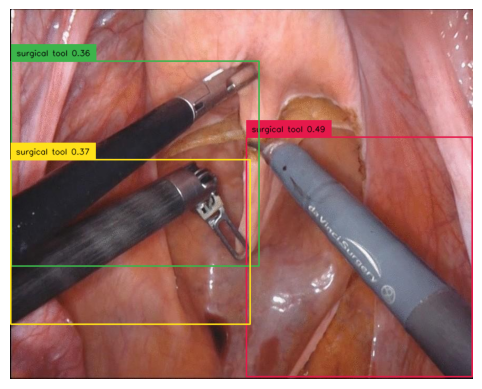

In [25]:
# from GroundingDINO.groundingdino.models import build_model
# from GroundingDINO.groundingdino.util import box_ops
# from GroundingDINO.groundingdino.util.slconfig import SLConfig
# from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap

import matplotlib.pyplot as plt

def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)


def detect(image, text_prompt, model, box_threshold = 0.3, text_threshold = 0.25):
  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases) # Update image_source variable
  print('logits:', logits)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB
  return annotated_frame, boxes

annotated_frame, detected_boxes = detect(image=image, text_prompt="surgical tool", model=groundingdino_model) # Update image variable
predicted_img = Image.fromarray(annotated_frame)
plt.imshow(predicted_img)
plt.axis('OFF');

MSE error:

In [26]:
detected_boxes

tensor([[0.7550, 0.6704, 0.4873, 0.6478],
        [0.2704, 0.4182, 0.5357, 0.5535],
        [0.2601, 0.6302, 0.5168, 0.4449]])

Find the Euclidean distance between the detected boxes

In [27]:
# import tensorflow as tf
# pt_grounded_boxA = tf.constant([0.7550, 0.6704, 0.4873, 0.6478])
# pt_kernel51_boxA = tf.constant([0.7676, 0.6699, 0.4654, 0.6584])
# pt_grounded_boxB = tf.constant([0.2704, 0.4182, 0.5357, 0.5535])
# pt_kernel51_boxB = tf.constant([0.2609, 0.6390, 0.5216, 0.4460])
# pt_grounded_boxC = tf.constant( [0.2601, 0.6302, 0.5168, 0.4449])
# pt_kernel51_boxC = tf.constant([0.2710, 0.4935, 0.5416, 0.7352])

# #Print Euclidean Distances
# print("Euclidean Distance:",tf.norm(pt_grounded_boxA - pt_kernel51_boxA,ord='euclidean'))
# print("Euclidean Distance:",tf.norm(pt_grounded_boxB - pt_kernel51_boxB,ord='euclidean'))
# print("Euclidean Distance:",tf.norm(pt_grounded_boxC - pt_kernel51_boxC,ord='euclidean'))

SAM for Segmentation from Detected Bounding Box:

In [33]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!pip -q install 'git+https://github.com/facebookresearch/segment-anything.git' torchmetrics

--2023-12-13 00:37:00--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.19, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   212MB/s    in 12s     

2023-12-13 00:37:12 (198 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 4.6 MB/s eta 0:00:00


Restart Runtime, please! (if segment_anything not found)

In [34]:
%cd /content/Grounded-Segment-Anything
from segment_anything import build_sam, SamPredictor
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sam_checkpoint = 'sam_vit_h_4b8939.pth'
sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))


[Errno 2] No such file or directory: '/content/Grounded-Segment-Anything'
/content


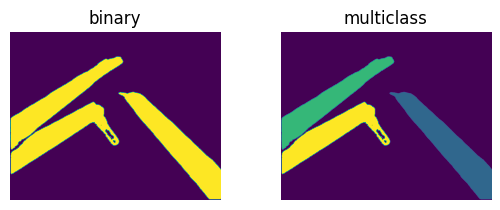

In [35]:
import numpy as np

def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()


def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))


segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
# annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)
# instance_seg1 = Image.fromarray(annotated_frame_with_mask)
binary_seg = segmented_frame_masks.squeeze().any(axis=0)
plt.subplot(221)
plt.title('binary')
plt.imshow(binary_seg);
plt.axis('OFF');

import torch
mask_multiclass = torch.zeros((segmented_frame_masks.shape[2:]))
mask_multiclass[segmented_frame_masks[0,0] == 1] = 1
mask_multiclass[segmented_frame_masks[1,0] == 1] = 2
mask_multiclass[segmented_frame_masks[2,0] == 1] = 3

plt.subplot(222)
plt.title('multiclass')
plt.imshow(mask_multiclass);
plt.axis('OFF');

Intersection over Union (IoU)

In [36]:
# segmented_frame_masks.sum(), segmented_frame_masks.shape

In [37]:
# segmented_frame_masks.sum()

Calculating segmentation metrics: Dice Similarity Coefficient (DSC)

binary dice: tensor(1.)
multiclass dice: tensor(1.)
binary dice: tensor(0.9589)


tensor([[ 576.6592,   83.2000, 1023.7500,  265.6000],
        [   1.5996,  230.4000,  902.9795,  657.6000],
        [ 505.4766,  433.6000, 1023.7500,  600.8000]])

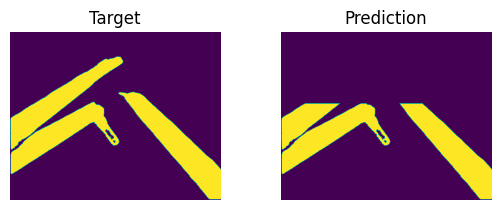

In [38]:
from torchmetrics.classification import Dice
dice_global = Dice(average='micro')
dice_cls_wise = Dice(average='macro', num_classes=4)
preds = binary_seg.int()
target = binary_seg.int()
binary_dice = dice_global(preds, target)
print('binary dice:', binary_dice)

multiclass_dice = dice_cls_wise(mask_multiclass.int(), mask_multiclass.int())

print('multiclass dice:', multiclass_dice)

preds = binary_seg.int()
target = binary_seg.int()

preds[:300,][preds[:300,]==1] = 0
binary_dice = dice_global(preds, target)
print('binary dice:', binary_dice)

plt.subplot(221)
plt.title('Target')
plt.imshow(target);
plt.axis('OFF');

plt.subplot(222)
plt.title('Prediction')
plt.imshow(preds);
plt.axis('OFF');


import cv2
cv2.imwrite('GT.png', np.array(binary_seg).astype(float))
cv2.imwrite('pred.png', np.array(binary_seg).astype(float))

import torch

input_boxes = [
    [721, 104, 1280, 332],
    [2, 288, 1129, 822],
    [632, 542, 1280, 751]
]
input_boxes = torch.tensor(np.array(input_boxes))
sam_predictor.transform.apply_boxes_torch(input_boxes, [1280, 1024])



Segmentation performance with clean image Vs filtering:

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


logits: tensor([0.4811, 0.3472, 0.3485])
logits: tensor([0.3463, 0.3088, 0.3636])
Detection mIoU: tensor(0.6107)
Segmentation dice: tensor(0.5979)


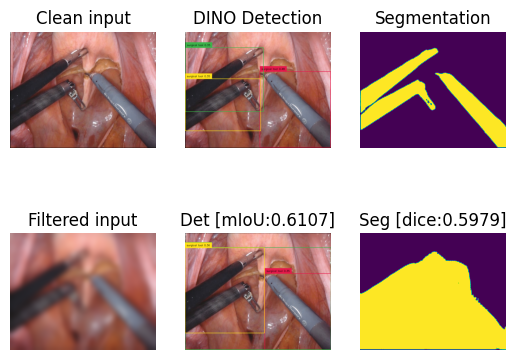

In [39]:
import urllib.request
from PIL import Image
import matplotlib.pyplot as plt
from groundingdino.util.inference import annotate, load_image, predict
#Clean Input
#input preparation
image_url = "https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg"
local_image_path = 'clean_input.png'
urllib.request.urlretrieve(image_url, local_image_path)
img = Image.open(local_image_path)
plt.subplot(231)
plt.axis('OFF')
plt.title('Clean input')
plt.imshow(img)

#DINO Detection
image_source, image = load_image(local_image_path)
annotated_frame, detected_boxes = detect(image, text_prompt="surgical tool", model=groundingdino_model)
predicted_img = Image.fromarray(annotated_frame)
plt.subplot(232)
plt.imshow(predicted_img)
plt.axis('OFF')
plt.title('DINO Detection')

#SAM Binary Segmentation
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
binary_seg = segmented_frame_masks.squeeze().any(axis=0)
plt.subplot(233)
plt.imshow(binary_seg)
plt.axis('OFF')
plt.title('Segmentation');

################################################################################
#Filtered Input
filtered_image_path = '/content/perturbed_imgs/blu_6.png'
# filtered_img = Image.open(filtered_image_path)
filtered_image_source, filtered_image = load_image(filtered_image_path)
plt.subplot(234)
plt.axis('OFF')
plt.title('Filtered input')
plt.imshow(filtered_image_source)

#DINO Detection
filtered_image_source, filtered_image = load_image(filtered_image_path)
filtered_annotated_frame, filtered_detected_boxes = detect(filtered_image, text_prompt="surgical tool", model=groundingdino_model)
filtered_predicted_img = Image.fromarray(filtered_annotated_frame)
plt.subplot(235)
plt.imshow(filtered_predicted_img)
plt.axis('OFF')

from groundingdino.util import box_ops
clean_boxes_xyxy = box_ops.box_cxcywh_to_xyxy(detected_boxes)
filtered_boxes_xyxy = box_ops.box_cxcywh_to_xyxy(filtered_detected_boxes)
IoU_All = box_ops.generalized_box_iou(clean_boxes_xyxy, filtered_boxes_xyxy)
mIoU = IoU_All.diag().sum()/len(clean_boxes_xyxy)
plt.title('Det [mIoU:{:0.4f}]'.format(mIoU))
print('Detection mIoU:', mIoU)

#SAM Binary Segmentation
filtered_segmented_frame_masks = segment(filtered_image_source, sam_predictor, boxes=filtered_detected_boxes)
filtered_binary_seg = filtered_segmented_frame_masks.squeeze().any(axis=0)
plt.subplot(236)
plt.imshow(filtered_binary_seg)
plt.axis('OFF')

#Dice Calculation
from torchmetrics.classification import Dice
dice_global = Dice(average='micro')
target = binary_seg.int()# prediction of clean input considered as target
filtered_preds = filtered_binary_seg.int()
binary_dice = dice_global(filtered_preds, target)
plt.title('Seg [dice:{:0.4f}]'.format(binary_dice));
print('Segmentation dice:', binary_dice)

Customized Drawing bbox:

logits: tensor([0.3463, 0.3088, 0.3636])


(-0.5, 883.5, 705.5, -0.5)

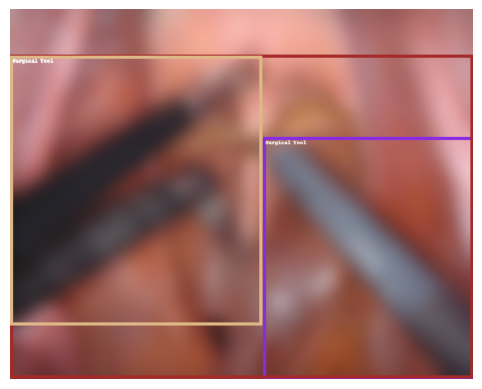

In [40]:
from groundingdino.util import box_ops
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.colors as colors

filtered_image_path = '/content/perturbed_imgs/blu_6.png'
filtered_image_source, filtered_image = load_image(filtered_image_path)
# image_source, image = load_image(local_image_path)
annotated_frame, detected_boxes = detect(filtered_image, text_prompt="surgical tool", model=groundingdino_model)

color_list = list(colors.cnames.values())
image_pil = Image.fromarray(filtered_image_source)
color = tuple(np.random.randint(0, 255, size=3).tolist())
draw = ImageDraw.Draw(image_pil)

boxes_xyxy = box_ops.box_cxcywh_to_xyxy(detected_boxes)
H, W, C = annotated_frame.shape
boxes = boxes_xyxy * torch.Tensor([W, H, W, H])
font = ImageFont.load_default()
# font = ImageFont.truetype("arial.ttf", size=1)
for idx, box in enumerate(boxes):
    x0, y0, x1, y1 = box
    x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)
    draw.rectangle([x0, y0, x1, y1], outline=color_list[idx+10], width=6)
    draw.text((x0+5, y0+5), str('Surgical Tool'), fill="white", font=font)
plt.imshow(image_pil)
plt.axis('OFF')